# Chipy Demonstration

Use this notebook in the Quantopian iPython IDE to see research for Chipy Quantopian Demonstration

Research will review the following:
1. Retrieve S&P500 prices and plot
2. Basic research on S&P500    
    * Annualize Returns
    * Show calcualtion for IR and Sharpe Ratio
    * Show definition of alpha and beta.
3. Retrieve some data for a new alpha signal
4. Compare annual returns
5. Build some plots with average returns.
6. Setup the strategy

In [27]:
#Initialization
import numpy as np
import pandas as pd
import datetime as dt
import pyfolio as pf
import math
import matplotlib
import matplotlib.pyplot as plt

Stock market research starts with the benchmark. Regardless of your convictions in rational markets or behavioral finance, creating a portfolio starts first with understanding the index. We'll start with the S&P 500.

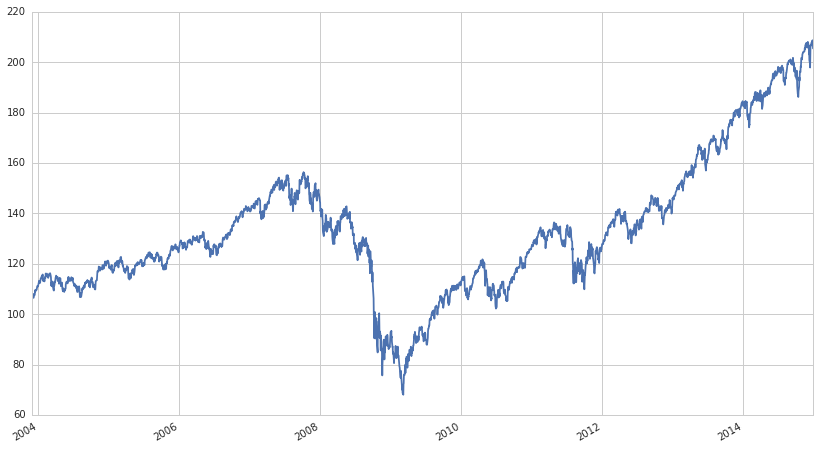

In [28]:
#Use the ticker for the Spider S&P500 ETF
sp500 = symbols('SPY')
#Get the pricing data. Zipline functions return a pandas DataSeries
sp500_prices = get_pricing(sp500,
                   fields='close_price', 
                   start_date='2003-12-01', #From April 2007 through the end of last year
                   end_date='2014-12-31')
#Plot the price
sp500_prices.plot() 

After falling off a cliff in late 2008, it is easy to see the market has been on a slightly bumpy but generally upward trend since early 2009. It got back to pre-recession peak levels in the first half of 2014. You will also note that the price level doesn't match the index level. That is because this is the ETF price not the actual index value.

Prices are good, but let's start looking at returns.  First we will calculate the daily change and then we will look at a cumulative return chart.

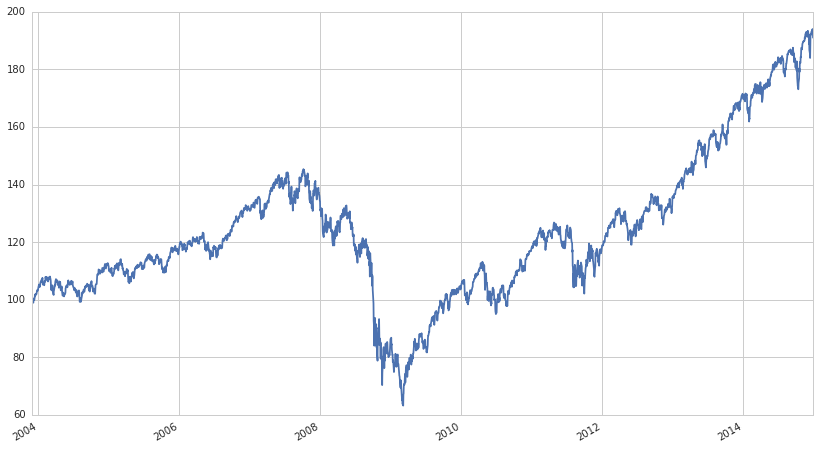

In [29]:
#Create a DataSeries of price changes for S&P500
sp500_returns = sp500_prices.pct_change().dropna()

#Use a cumulative returns function and plot from the pyfolio packaage. 
((pf.timeseries.cum_returns(sp500_returns)+1)*100).plot();

Looks familiar right?  Thats good, it should look just like the price chart, but it should index from 0.  You can also set it to index at other values. The indexed return is helpful as it helps us understand how an investment would have done over time. If invested in April of 2004, 100 dollars in the market would have gone up almost 40% by the end of 2008 and then dropped 40% by early 2009.  If you stayed in the market, your investment would rally and almost triple from the lowest point in 2009 to the end of last year. Overall that 100 dollars in 2004 would be worth 180 assuming no other changes.

Now that we have a better sense of what the market has done, let's think of other ways to break down the data. One chart have found helpful is a histogram of the daily returns.

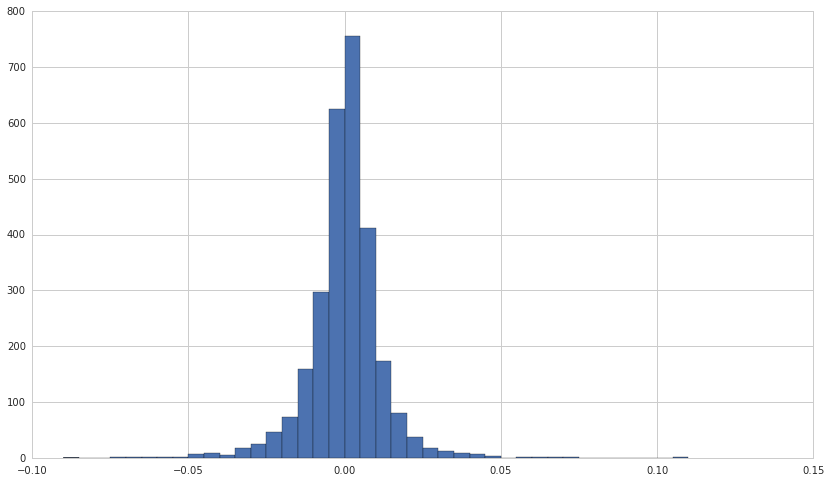

In [30]:
sp500_returns.hist(bins=np.arange(round(min(sp500_returns),2),round(max(sp500_returns),2)+.005, 0.005))

Interesting. Slightly more days with positive returns. This is helpful to remember because we can then realize that beating the market doesn't require a portfolio that doesn't have negative return days, but simply has a few more positive days than negative ones. 

We could build more charts/tables to further build out the analysis, but luckily pyfolio has some built in tools to help out.

Entire data start date: 2003-12-02 00:00:00+00:00
Entire data end date: 2014-12-31 00:00:00+00:00


Backtest Months: 132
                   Backtest
annual_return          0.08
annual_volatility      0.19
sharpe_ratio           0.40
calmar_ratio           0.14
stability              0.29
max_drawdown          -0.56
omega_ratio            1.08
sortino_ratio          0.51
skewness              -0.03
kurtosis              11.49
alpha                  0.00
beta                   1.00

Worst Drawdown Periods
   net drawdown in %                  peak date                valley date  \
0              56.48  2007-10-09 00:00:00+00:00  2009-03-09 00:00:00+00:00   
2               9.22  2007-07-19 00:00:00+00:00  2007-08-15 00:00:00+00:00   
1               7.70  2014-09-18 00:00:00+00:00  2014-10-16 00:00:00+00:00   
4               6.08  2013-05-21 00:00:00+00:00  2013-06-24 00:00:00+00:00   
3               5.69  2014-01-15 00:00:00+00:00  2014-02-03 00:00:00+00:00   

               recover

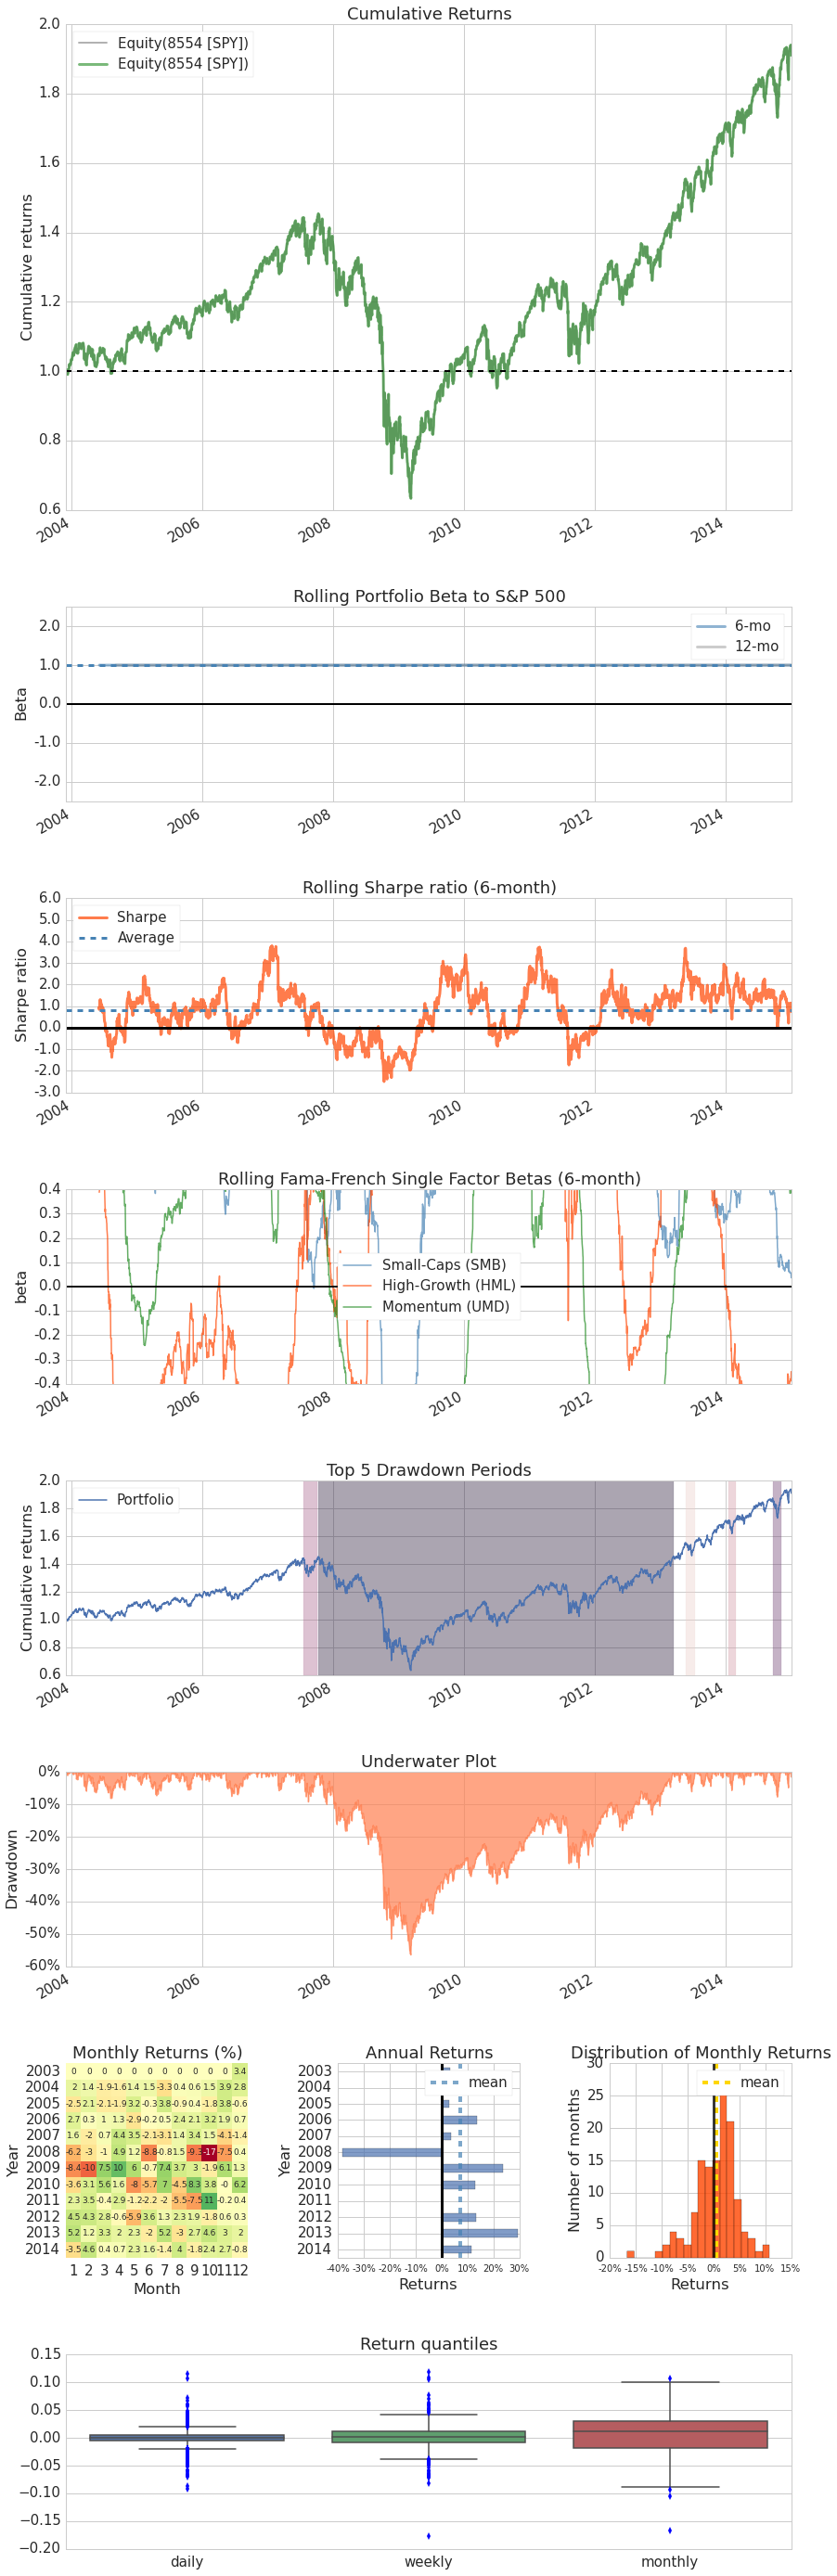

In [31]:
pf.create_returns_tear_sheet(sp500_returns)

That tearsheet can be pretty handy. There is a lot there, more than we have time to cover in this presentation. Some of the charts are kind of obvious, some you will probably need to google. In my experience, this is probably more than most managers might require in a single run, but they do like to have a variety of information available when evaluating a strategy.

So, now we have a benchmark. 7% annual return. At this point we want to start thinking about a strategy. Any ideas? Let's start by annualizing the returns.

In [32]:
sp500_returns.columns=['daily_returns']
sp500_returns_df=pd.DataFrame(sp500_returns)
sp500_returns_df.columns = ['daily_returns']
sp500_returns_df['datadate']=sp500_returns.index
sp500_returns_df['year']=pd.to_datetime(pd.Series(sp500_returns_df['datadate'])).dt.year
sp500_returns_df['return_ratio']=sp500_returns_df['daily_returns'].apply(math.log1p)
sp500_returns_grp = sp500_returns_df.groupby('year')
sp500_returns_annual = sp500_returns_grp['return_ratio'].agg([np.sum,np.std,np.mean])
sp500_returns_annual['annual_return']=sp500_returns_annual['sum'].apply(math.exp)-1
sp500_returns_annual['Year']=sp500_returns_annual.index
sp500=sp500_returns_annual[['Year','annual_return']]
sp500


,Year,annual_return
year,,
2003,2003,0.033653
2004,2004,0.088587
2005,2005,0.029081
2006,2006,0.135999
2007,2007,0.034770
2008,2008,-0.383691
2009,2009,0.234929
2010,2010,0.128859
2011,2011,-0.001669


So these are the annual returns. If we compared these to the published annual returns we would see that they are slightly too low.  That is because this is raw price change not the total (including dividends) return.  This isn't ideal, but for the sake of a demonstration it is okay.

Other than that, the returns pass the sniff test.  Big drop in 2008, run ups in the years since with 2011 being essentially flat.

So now we need to think of something to build our strategy. Quantopian has a lot of resources that might help generate some ideas. We are going way outside the box. What if we built a strategy around the Cubs? Maybe we could set it up so we buy when the Cubs win and sell when they lose.

Baseball Reference is a data analyst friend website, but unfortunately this IDE doesn't current support packages like requests and BeautifulSoup.  So we swith over to a seperate instance of iPython. We will load in the supporting data via CSV files.

In [33]:
cubs_rec = local_csv('record.csv')
cubs_rec.head()

,Year,G,W,L,W-L%
0,2015,132,75,57,0.568
1,2014,162,73,89,0.451
2,2013,162,66,96,0.407
3,2012,162,61,101,0.377
4,2011,162,71,91,0.438


I loaded the file from a locally stored CSV. It seems like Quantopian will soon, but doesn't yet support the same fetch from http service in the research module that exists in the backtesting module. Next, let's look at the relationship between the annual record and annual returns.  If we find something, we might be able to use it in an actual strategy.

In [34]:
#Combine the relevent pieces of data
sp500_cubs = pd.merge(sp500,cubs_rec[['Year','W-L%']],left_on='Year', right_on = 'Year')

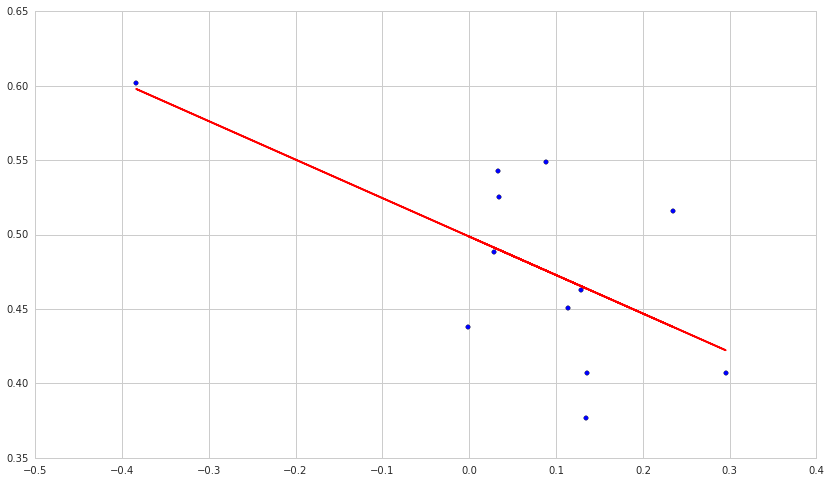

In [53]:
ax = plt.subplot()

fit = np.polyfit(sp500_cubs['annual_return'], sp500_cubs['W-L%'], 1)
ax.plot(sp500_cubs['annual_return'], fit[0] * sp500_cubs['annual_return'] + fit[1], color='red')
ax.scatter(sp500_cubs['annual_return'], sp500_cubs['W-L%'])


Oops, looke likes we should probably sell when the Cubs win and buy when they lose.